Starting complete data exploration for Spanish MeSH classification...
Loading data...
✓ Loaded 44604 articles

BASIC DATASET STATISTICS
Total articles: 44604
Date range: 1988 - 2025
Average abstract length: 193.51 words
Structured abstracts: 24856

Language distribution:
  mixed_or_unknown: 13771 (30.9%)
  english: 30667 (68.8%)
  spanish: 166 (0.4%)

Missing data analysis:
  Articles without abstracts: 0
  Articles without MeSH terms: 0
  Articles without titles: 0

MESH TERMS EXTRACTION AND ANALYSIS
Total unique MeSH terms: 14273
Total MeSH term occurrences: 463425
Major topic terms: 56821 (12.3%)
Average MeSH terms per article: 10.39
Median MeSH terms per article: 10
Max MeSH terms in single article: 37
Min MeSH terms in single article: 1

MESH TERMS FREQUENCY ANALYSIS
Most frequent MeSH terms:
  Humans: 42853
  Female: 23589
  Male: 22204
  Adult: 12843
  Middle Aged: 12637
  Aged: 9857
  Adolescent: 7510
  Spain: 7027
  Child: 7011
  Cross-Sectional Studies: 5678
  Retrospective S

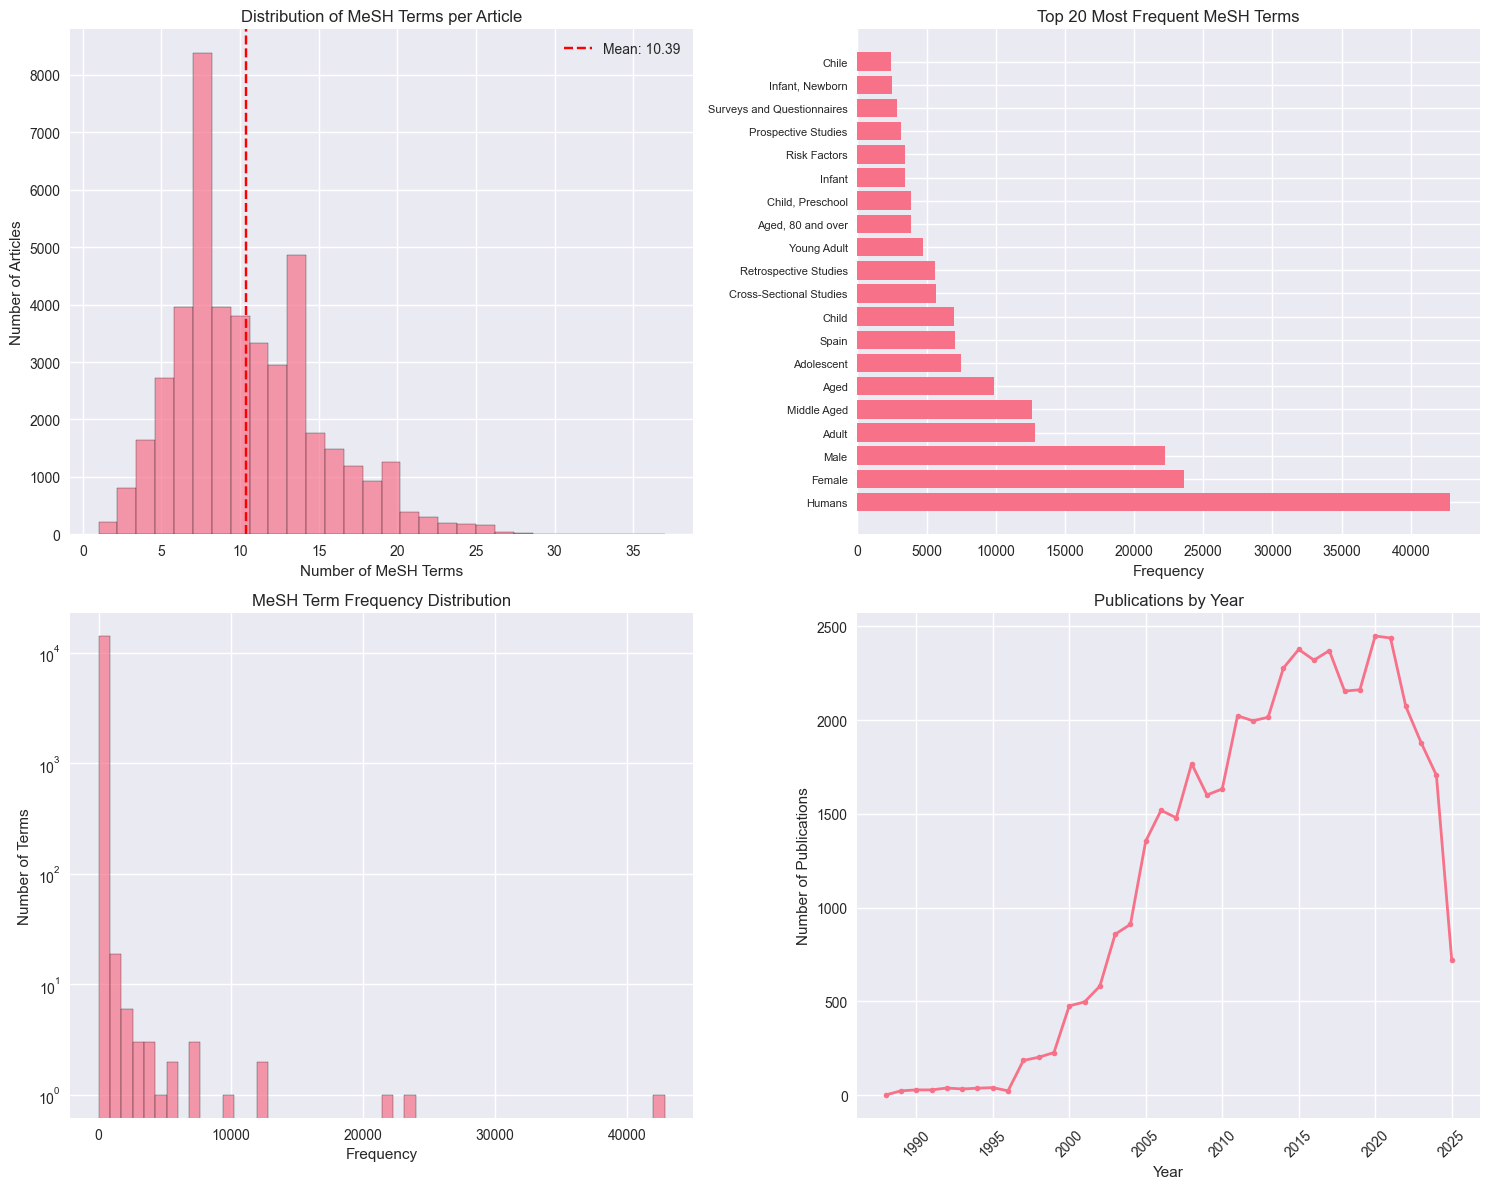


PREPARING DATA FOR CLASSIFICATION
Prepared 44604 articles for classification
Articles with Spanish translations: 44438
Articles with original text only: 166
Articles with Spanish translations that will be used: 44438
Filtering articles with MeSH terms between 5 and 17
After filtering: 38411 articles

Data splits:
  Training set: 23046 articles (60.0%)
  Validation set: 7682 articles (20.0%)
  Test set: 7683 articles (20.0%)

MeSH vocabulary statistics:
  Total unique MeSH terms: 13450
  Terms appearing ≥5 times: 6046
  Terms appearing ≥10 times: 3764

✓ Saved data splits to train_data.json, val_data.json, test_data.json

TEXT CHARACTERISTICS ANALYSIS
Text length statistics (in words):
  Mean: 224.92
  Median: 222.00
  Std: 105.97
  Min: 49
  Max: 1904
  95th percentile: 355

Translation analysis:
  Articles with Spanish translations: 22963 (99.6%)
  Articles using original text: 83 (0.4%)

Language detection (sample of 100 articles):
  Likely Spanish: 100
  Likely English: 0
  Unclear

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class SpanishMeSHDataExplorer:
    def __init__(self, json_file_path):
        """
        Initialize the data explorer with the JSON file path
        """
        self.json_file_path = json_file_path
        self.data = None
        self.articles_df = None
        self.mesh_terms_flat = []
        self.mesh_descriptors = []
        
    def load_data(self):
        """Load and parse the JSON data"""
        print("Loading data...")
        with open(self.json_file_path, 'r', encoding='utf-8') as f:
            self.data = json.load(f)
        
        # Convert articles to DataFrame
        self.articles_df = pd.DataFrame(self.data['articles'])
        print(f"✓ Loaded {len(self.articles_df)} articles")
        
    def basic_statistics(self):
        """Print basic statistics about the dataset"""
        print("\n" + "="*60)
        print("BASIC DATASET STATISTICS")
        print("="*60)
        
        # General statistics
        print(f"Total articles: {len(self.articles_df)}")
        print(f"Date range: {self.data['statistics']['year_range']['earliest']} - {self.data['statistics']['year_range']['latest']}")
        print(f"Average abstract length: {self.data['statistics']['avg_abstract_length']:.2f} words")
        print(f"Structured abstracts: {self.data['statistics']['structured_abstracts']}")
        
        # Language distribution
        print(f"\nLanguage distribution:")
        for lang, count in self.data['statistics']['language_distribution'].items():
            percentage = (count / self.data['statistics']['total_articles']) * 100
            print(f"  {lang}: {count} ({percentage:.1f}%)")
            
        # Check for missing data
        print(f"\nMissing data analysis:")
        print(f"  Articles without abstracts: {self.articles_df['abstract'].isna().sum()}")
        print(f"  Articles without MeSH terms: {self.articles_df['mesh_terms'].isna().sum()}")
        print(f"  Articles without titles: {self.articles_df['title'].isna().sum()}")
        
    def extract_mesh_terms(self):
        """Extract and analyze MeSH terms from all articles"""
        print("\n" + "="*60)
        print("MESH TERMS EXTRACTION AND ANALYSIS")
        print("="*60)
        
        all_mesh_descriptors = []
        all_mesh_names = []
        mesh_per_article = []
        major_topic_count = 0
        total_mesh_count = 0
        
        for idx, article in self.articles_df.iterrows():
            article_mesh = []
            mesh_terms = article['mesh_terms']
            
            # Check if mesh_terms exists and is not empty
            if mesh_terms is not None and len(mesh_terms) > 0:
                for mesh_term in mesh_terms:
                    if isinstance(mesh_term, dict) and 'descriptor' in mesh_term:
                        descriptor = mesh_term['descriptor']
                        if isinstance(descriptor, dict) and 'name' in descriptor:
                            descriptor_name = descriptor['name']
                            descriptor_ui = descriptor.get('ui', '')
                            is_major = descriptor.get('major_topic', False)
                            
                            all_mesh_descriptors.append({
                                'name': descriptor_name,
                                'ui': descriptor_ui,
                                'major_topic': is_major,
                                'article_id': article['pmid']
                            })
                            
                            all_mesh_names.append(descriptor_name)
                            article_mesh.append(descriptor_name)
                            
                            if is_major:
                                major_topic_count += 1
                            total_mesh_count += 1
                        
            mesh_per_article.append(len(article_mesh))
        
        self.mesh_terms_flat = all_mesh_names
        self.mesh_descriptors = all_mesh_descriptors
        
        print(f"Total unique MeSH terms: {len(set(all_mesh_names))}")
        print(f"Total MeSH term occurrences: {len(all_mesh_names)}")
        print(f"Major topic terms: {major_topic_count} ({(major_topic_count/total_mesh_count)*100:.1f}%)")
        print(f"Average MeSH terms per article: {np.mean(mesh_per_article):.2f}")
        print(f"Median MeSH terms per article: {np.median(mesh_per_article):.0f}")
        print(f"Max MeSH terms in single article: {max(mesh_per_article)}")
        print(f"Min MeSH terms in single article: {min(mesh_per_article)}")
        
        return mesh_per_article
    
    def analyze_mesh_distribution(self):
        """Analyze the distribution of MeSH terms"""
        print("\n" + "="*60)
        print("MESH TERMS FREQUENCY ANALYSIS")
        print("="*60)
        
        # Count frequency of each MeSH term
        mesh_counter = Counter(self.mesh_terms_flat)
        
        print(f"Most frequent MeSH terms:")
        for term, count in mesh_counter.most_common(20):
            print(f"  {term}: {count}")
        
        # Analyze distribution
        frequencies = list(mesh_counter.values())
        print(f"\nFrequency distribution:")
        print(f"  Terms appearing once: {sum(1 for f in frequencies if f == 1)}")
        print(f"  Terms appearing 2-5 times: {sum(1 for f in frequencies if 2 <= f <= 5)}")
        print(f"  Terms appearing 6-10 times: {sum(1 for f in frequencies if 6 <= f <= 10)}")
        print(f"  Terms appearing >10 times: {sum(1 for f in frequencies if f > 10)}")
        
        return mesh_counter
    
    def analyze_journals(self):
        """Analyze journal distribution"""
        print("\n" + "="*60)
        print("JOURNAL ANALYSIS")
        print("="*60)
        
        # Analyze journals
        journal_names = []
        for idx, article in self.articles_df.iterrows():
            if 'journal' in article and article['journal']:
                journal_data = article['journal']
                if isinstance(journal_data, dict) and 'title' in journal_data:
                    journal_names.append(journal_data['title'])
        
        journal_counter = Counter(journal_names)
        print(f"Total unique journals: {len(journal_counter)}")
        print(f"\nTop 10 journals by article count:")
        for journal, count in journal_counter.most_common(10):
            print(f"  {journal}: {count}")
    
    def create_visualizations(self, mesh_counter, mesh_per_article):
        """Create various visualizations"""
        print("\n" + "="*60)
        print("CREATING VISUALIZATIONS")
        print("="*60)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Distribution of MeSH terms per article
        axes[0, 0].hist(mesh_per_article, bins=30, alpha=0.7, edgecolor='black')
        axes[0, 0].set_title('Distribution of MeSH Terms per Article')
        axes[0, 0].set_xlabel('Number of MeSH Terms')
        axes[0, 0].set_ylabel('Number of Articles')
        axes[0, 0].axvline(np.mean(mesh_per_article), color='red', linestyle='--', 
                          label=f'Mean: {np.mean(mesh_per_article):.2f}')
        axes[0, 0].legend()
        
        # 2. Top 20 most frequent MeSH terms
        top_20_terms = dict(mesh_counter.most_common(20))
        axes[0, 1].barh(range(len(top_20_terms)), list(top_20_terms.values()))
        axes[0, 1].set_yticks(range(len(top_20_terms)))
        axes[0, 1].set_yticklabels(list(top_20_terms.keys()), fontsize=8)
        axes[0, 1].set_title('Top 20 Most Frequent MeSH Terms')
        axes[0, 1].set_xlabel('Frequency')
        
        # 3. MeSH term frequency distribution (log scale)
        frequencies = list(mesh_counter.values())
        axes[1, 0].hist(frequencies, bins=50, alpha=0.7, edgecolor='black')
        axes[1, 0].set_title('MeSH Term Frequency Distribution')
        axes[1, 0].set_xlabel('Frequency')
        axes[1, 0].set_ylabel('Number of Terms')
        axes[1, 0].set_yscale('log')
        
        # 4. Publication years distribution
        years = []
        for idx, article in self.articles_df.iterrows():
            if 'publication_info' in article and article['publication_info']:
                pub_info = article['publication_info']
                if isinstance(pub_info, dict) and 'year' in pub_info:
                    years.append(pub_info['year'])
        
        year_counter = Counter(years)
        sorted_years = sorted(year_counter.items())
        
        axes[1, 1].plot([y[0] for y in sorted_years], [y[1] for y in sorted_years], 
                       marker='o', linewidth=2, markersize=4)
        axes[1, 1].set_title('Publications by Year')
        axes[1, 1].set_xlabel('Year')
        axes[1, 1].set_ylabel('Number of Publications')
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig('mesh_data_exploration.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def prepare_classification_data(self):
        """Prepare data for classification and create train/val/test splits"""
        print("\n" + "="*60)
        print("PREPARING DATA FOR CLASSIFICATION")
        print("="*60)
        
        # Create dataset for classification
        classification_data = []
        articles_with_spanish = 0
        articles_without_spanish = 0
        
        for idx, article in self.articles_df.iterrows():
            # Extract text (title + Spanish translated abstract)
            text_parts = []
            
            if 'title' in article and article['title']:
                title = str(article['title']).strip('[].')  # Remove brackets and periods
                #text_parts.append(title)
            
            # Use Spanish translation if available, otherwise fall back to original
            spanish_text = None
            if 'abstract' in article and article['abstract']:
                abstract_data = article['abstract']
                if isinstance(abstract_data, dict):
                    # Check for Spanish translation first
                    if 'spanish_translation' in abstract_data:
                        spanish_translation = abstract_data['spanish_translation']
                        if isinstance(spanish_translation, dict) and spanish_translation.get('success', False):
                            spanish_text = spanish_translation.get('text', '')
                            if spanish_text:
                                text_parts.append(spanish_text)
                                articles_with_spanish += 1
                    
                    # If no Spanish translation, use original text
                    if not spanish_text and abstract_data.get('has_content', False):
                        abstract_text = abstract_data.get('full_text', '')
                        if abstract_text:
                            text_parts.append(abstract_text)
                            articles_without_spanish += 1
            
            if not text_parts:
                continue
                
            full_text = ' '.join(text_parts)
            
            # Extract MeSH terms
            mesh_terms = []
            mesh_terms_data = article['mesh_terms']
            if mesh_terms_data is not None and len(mesh_terms_data) > 0:
                for mesh_term in mesh_terms_data:
                    if isinstance(mesh_term, dict) and 'descriptor' in mesh_term:
                        descriptor = mesh_term['descriptor']
                        if isinstance(descriptor, dict) and 'name' in descriptor:
                            mesh_terms.append(descriptor['name'])
            
            if mesh_terms:  # Only include articles with MeSH terms
                classification_data.append({
                    'pmid': article['pmid'],
                    'title': title,
                    'text': full_text,
                    'mesh_terms': mesh_terms,
                    'num_mesh_terms': len(mesh_terms),
                    'has_spanish_translation': spanish_text is not None
                })
        
        print(f"Prepared {len(classification_data)} articles for classification")
        print(f"Articles with Spanish translations: {articles_with_spanish}")
        print(f"Articles with original text only: {articles_without_spanish}")
        
        # Convert to DataFrame
        df = pd.DataFrame(classification_data)
        
        if len(df) == 0:
            print("No articles found with valid text and MeSH terms!")
            return None, None, None, None
        
        # Report on Spanish vs English content
        spanish_only = df[df['has_spanish_translation'] == True]
        print(f"Articles with Spanish translations that will be used: {len(spanish_only)}")
        
        # Filter out articles with very few or too many MeSH terms
        mesh_counts = df['num_mesh_terms']
        q1 = mesh_counts.quantile(0.1)
        q9 = mesh_counts.quantile(0.9)
        
        print(f"Filtering articles with MeSH terms between {q1:.0f} and {q9:.0f}")
        df_filtered = df[(df['num_mesh_terms'] >= q1) & (df['num_mesh_terms'] <= q9)]
        print(f"After filtering: {len(df_filtered)} articles")
        
        if len(df_filtered) < 10:
            print("Too few articles after filtering. Using all available data.")
            df_filtered = df
        
        # Create train/validation/test splits
        try:
            # Try stratified split first
            train_df, temp_df = train_test_split(df_filtered, test_size=0.4, random_state=42, 
                                               stratify=pd.cut(df_filtered['num_mesh_terms'], bins=min(5, len(df_filtered)//10)))
            val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42,
                                             stratify=pd.cut(temp_df['num_mesh_terms'], bins=min(5, len(temp_df)//10)))
        except ValueError:
            # If stratified split fails, use random split
            print("Stratified split failed, using random split...")
            train_df, temp_df = train_test_split(df_filtered, test_size=0.4, random_state=42)
            val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
        
        print(f"\nData splits:")
        print(f"  Training set: {len(train_df)} articles ({len(train_df)/len(df_filtered)*100:.1f}%)")
        print(f"  Validation set: {len(val_df)} articles ({len(val_df)/len(df_filtered)*100:.1f}%)")
        print(f"  Test set: {len(test_df)} articles ({len(test_df)/len(df_filtered)*100:.1f}%)")
        
        # Analyze MeSH term vocabulary
        all_mesh_terms = []
        for mesh_list in df_filtered['mesh_terms']:
            all_mesh_terms.extend(mesh_list)
        
        vocab_counter = Counter(all_mesh_terms)
        print(f"\nMeSH vocabulary statistics:")
        print(f"  Total unique MeSH terms: {len(vocab_counter)}")
        print(f"  Terms appearing ≥5 times: {sum(1 for count in vocab_counter.values() if count >= 5)}")
        print(f"  Terms appearing ≥10 times: {sum(1 for count in vocab_counter.values() if count >= 10)}")
        
        # Save the splits
        train_df.to_json('train_data.json', orient='records', force_ascii=False, indent=2)
        val_df.to_json('val_data.json', orient='records', force_ascii=False, indent=2)
        test_df.to_json('test_data.json', orient='records', force_ascii=False, indent=2)
        
        print(f"\n✓ Saved data splits to train_data.json, val_data.json, test_data.json")
        
        return train_df, val_df, test_df, vocab_counter
    
    def analyze_text_characteristics(self, df):
        """Analyze text characteristics for the classification dataset"""
        print("\n" + "="*60)
        print("TEXT CHARACTERISTICS ANALYSIS")
        print("="*60)
        
        # Text length analysis
        text_lengths = [len(text.split()) for text in df['text']]
        
        print(f"Text length statistics (in words):")
        print(f"  Mean: {np.mean(text_lengths):.2f}")
        print(f"  Median: {np.median(text_lengths):.2f}")
        print(f"  Std: {np.std(text_lengths):.2f}")
        print(f"  Min: {min(text_lengths)}")
        print(f"  Max: {max(text_lengths)}")
        print(f"  95th percentile: {np.percentile(text_lengths, 95):.0f}")
        
        # Language detection and translation analysis
        spanish_indicators = ['el', 'la', 'de', 'en', 'un', 'una', 'con', 'para', 'por', 'que', 'del', 'los', 'las', 'es', 'son', 'se', 'su', 'sus']
        english_indicators = ['the', 'and', 'of', 'in', 'to', 'a', 'is', 'for', 'with', 'on', 'are', 'was', 'were', 'been', 'have', 'has', 'had']
        
        spanish_count = 0
        english_count = 0
        
        # Analyze translation coverage
        if 'has_spanish_translation' in df.columns:
            spanish_translated = df['has_spanish_translation'].sum()
            print(f"\nTranslation analysis:")
            print(f"  Articles with Spanish translations: {spanish_translated} ({spanish_translated/len(df)*100:.1f}%)")
            print(f"  Articles using original text: {len(df) - spanish_translated} ({(len(df) - spanish_translated)/len(df)*100:.1f}%)")
        
        # Sample language detection on first 100 texts
        sample_size = min(100, len(df))
        for i in range(sample_size):
            text = df.iloc[i]['text'].lower()
            spanish_score = sum(1 for word in spanish_indicators if f' {word} ' in text)
            english_score = sum(1 for word in english_indicators if f' {word} ' in text)
            
            if spanish_score > english_score:
                spanish_count += 1
            elif english_score > spanish_score:
                english_count += 1
        
        print(f"\nLanguage detection (sample of {sample_size} articles):")
        print(f"  Likely Spanish: {spanish_count}")
        print(f"  Likely English: {english_count}")
        print(f"  Unclear: {sample_size - spanish_count - english_count}")
        
        # Show sample Spanish translated text
        if 'has_spanish_translation' in df.columns:
            spanish_samples = df[df['has_spanish_translation'] == True]
            if len(spanish_samples) > 0:
                print(f"\nSample Spanish translated text:")
                sample_text = spanish_samples.iloc[0]['text'][:300] + "..." if len(spanish_samples.iloc[0]['text']) > 300 else spanish_samples.iloc[0]['text']
                print(f"  {sample_text}")
        
        return {
            'text_lengths': text_lengths,
            'spanish_count': spanish_count,
            'english_count': english_count,
            'sample_size': sample_size
        }
        
    def run_complete_analysis(self):
        """Run the complete data exploration pipeline"""
        print("Starting complete data exploration for Spanish MeSH classification...")
        
        # Load data
        self.load_data()
        
        # Basic statistics
        self.basic_statistics()
        
        # Extract and analyze MeSH terms
        mesh_per_article = self.extract_mesh_terms()
        
        # Analyze MeSH distribution
        mesh_counter = self.analyze_mesh_distribution()
        
        # Analyze journals
        self.analyze_journals()
        
        # Create visualizations
        self.create_visualizations(mesh_counter, mesh_per_article)
        
        # Prepare classification data
        train_df, val_df, test_df, vocab_counter = self.prepare_classification_data()
        
        # Analyze text characteristics
        self.analyze_text_characteristics(train_df)
        
        print("\n" + "="*60)
        print("DATA EXPLORATION COMPLETE!")
        print("="*60)
        print("Next steps for MeSH classification:")
        print("1. Use BioBERT as base model (most suitable for biomedical text)")
        print("2. Fine-tune on your Spanish medical data")
        print("3. Consider multi-label classification approach")
        print("4. Use the prepared train/val/test splits")
        print("5. Filter vocabulary based on frequency thresholds")
        
        return {
            'train_df': train_df,
            'val_df': val_df, 
            'test_df': test_df,
            'vocab_counter': vocab_counter,
            'mesh_counter': mesh_counter
        }

# Usage example:
if __name__ == "__main__":
    # Initialize the explorer with the translated dataset
    explorer = SpanishMeSHDataExplorer(r'..\data\translated_dataset.json')
    
    # Run complete analysis
    results = explorer.run_complete_analysis()
    
    # The results dictionary contains all the processed data ready for modeling